In [ ]:
# 02_model_training.ipynb
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch

In [ ]:
# -------------------------
# 2️⃣ Paramètres
# -------------------------
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10
ARCH = 'baseline'  # 'baseline', 'wide', 'deep'
IMAGE_SIZE = 224
PROCESSED_DIR = r"C:\Users\USER\Desktop\ecg-classification\data\processed"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = f"baseline_{ARCH}.pth"

In [ ]:
# -------------------------
# 3️⃣ Chargement des données
# -------------------------
images = np.load(f"{PROCESSED_DIR}/images.npy")
labels = np.load(f"{PROCESSED_DIR}/labels.npy")
images = images[:, np.newaxis, :, :]  # ajouter canal

images_tensor = torch.tensor(images, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(images_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {train_size}, Test size: {test_size}")

Train size: 742, Test size: 186


In [ ]:
# -------------------------
# 4️⃣ Définition du modèle CNN
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4, arch='baseline'):
        super(SimpleCNN, self).__init__()
        if arch == 'baseline':
            self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        elif arch == 'wide':
            self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        elif arch == 'deep':
            self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.arch = arch
        self.pool = nn.MaxPool2d(2,2)
        if arch == 'deep':
            self.fc1 = nn.Linear(64 * 28 * 28, 128)
        else:
            self.fc1 = nn.Linear((32 if arch != 'wide' else 64) * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        if self.arch == 'deep':
            x = F.relu(self.conv3(x))
            x = self.pool(x)
            x = x.view(-1, 64 * 28 * 28)
        else:
            x = x.view(-1, (32 if self.arch != 'wide' else 64) * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:

# -------------------------
# 5️⃣ Device, modèle, critère et optimiseur
# -------------------------
model = SimpleCNN(num_classes=4, arch=ARCH).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# -------------------------
# 6️⃣ MLflow setup
# -------------------------
mlflow.set_experiment("ECG_Classification_Tuning")
train_losses = []
train_accuracies = []

with mlflow.start_run():
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("architecture", ARCH)

c:\Users\USER\anaconda3\envs\ecg_project\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [10]:
 # -------------------------
# 7️⃣ Boucle d'entraînement
# -------------------------
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")
    mlflow.log_metric("train_loss", epoch_loss, step=epoch)
    mlflow.log_metric("train_accuracy", epoch_acc, step=epoch)



Epoch 1/10 - Loss: 1.9540 - Accuracy: 0.2871
Epoch 2/10 - Loss: 1.3825 - Accuracy: 0.3059
Epoch 3/10 - Loss: 1.3776 - Accuracy: 0.3032
Epoch 4/10 - Loss: 1.3865 - Accuracy: 0.3046
Epoch 5/10 - Loss: 1.3622 - Accuracy: 0.3113
Epoch 6/10 - Loss: 1.3480 - Accuracy: 0.3275
Epoch 7/10 - Loss: 1.3402 - Accuracy: 0.3585
Epoch 8/10 - Loss: 1.3085 - Accuracy: 0.3747
Epoch 9/10 - Loss: 1.2882 - Accuracy: 0.3827
Epoch 10/10 - Loss: 1.2221 - Accuracy: 0.4744


In [12]:
# -------------------------
# 8️⃣ Évaluation
# -------------------------
model.eval()
all_targets = []
all_preds = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
TN = np.diag(cm).sum() - np.trace(cm)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

sensitivity = TP / (TP + FN + 1e-8)  # éviter division par zéro
specificity = TN / (TN + FP + 1e-8)

try:
    auc = roc_auc_score(np.eye(4)[all_targets], np.eye(4)[all_preds], multi_class='ovr')
except:
    auc = 0.0

test_acc = np.mean(np.array(all_preds) == np.array(all_targets))
print(f"Test Accuracy: {test_acc:.4f}, Sensitivity: {sensitivity}, Specificity: {specificity}, AUC: {auc:.4f}")

mlflow.log_metric("test_accuracy", test_acc)
mlflow.log_metric("test_auc", auc)


Test Accuracy: 0.3656, Sensitivity: [0.50847458 0.11627907 0.50980392 0.21212121], Specificity: [0. 0. 0. 0.], AUC: 0.5592


In [14]:
# -------------------------
# 9️⃣ Sauvegarde modèle
# -------------------------
torch.save(model.state_dict(), MODEL_PATH)
mlflow.pytorch.log_model(model, "baseline_model")
print(f"Modèle sauvegardé sous {MODEL_PATH}")


2025/12/09 20:13:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 20:13:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle sauvegardé sous baseline_baseline.pth


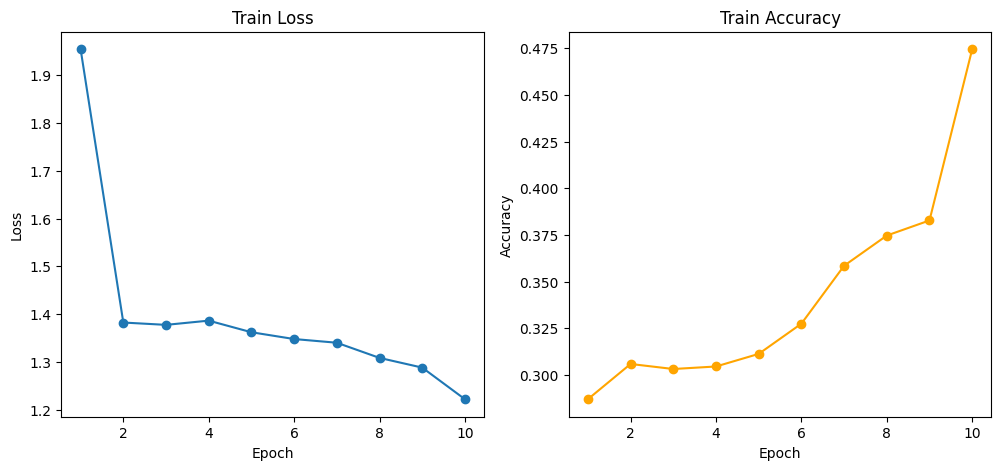

In [15]:

# -------------------------
# 10️⃣ Courbes Loss & Accuracy
# -------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,EPOCHS+1), train_losses, marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(range(1,EPOCHS+1), train_accuracies, marker='o', color='orange')
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [16]:
import os
print("Répertoire courant :", os.getcwd())

# Changer vers la racine du projet si nécessaire
os.chdir(r"C:\Users\USER\Desktop\ecg-classification")
print("Répertoire courant après changement :", os.getcwd())


Répertoire courant : C:\Users\USER\Desktop\ecg-classification
Répertoire courant après changement : C:\Users\USER\Desktop\ecg-classification


In [17]:
import numpy as np
PROCESSED_DIR = r"C:\Users\USER\Desktop\ecg-classification\data\processed"
images = np.load(f"{PROCESSED_DIR}/images.npy")
labels = np.load(f"{PROCESSED_DIR}/labels.npy")
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")


Images shape: (928, 224, 224), Labels shape: (928,)
